In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import torch

In [10]:
def plot_colored_quiver(grads, width=0.003, plot_min=False, title=None):
    fig, ax = plt.subplots()

    ax.scatter(grads["sigma"], grads["penalty"], c=grads["loss"], s=4)
    cobj = ax.quiver(grads["sigma"], grads["penalty"], -grads["sigma_g"], -grads["penalty_g"], 
                     grads["loss"], pivot='tail', scale=1, width=width, minshaft=1, headwidth=7,
                    )
    if plot_min:
        min_point = grads.iloc[grads["loss"].argmin()]
        ax.scatter(min_point["sigma"], min_point["penalty"], s=25, c="r")
    ax.set_xlabel("Sigma ($\gamma = 1/2\sigma^2$)")
    ax.set_ylabel("Penalty ($\lambda = e^{-p}$)")
    cbar = fig.colorbar(cobj, ax=ax)
    cbar.ax.set_ylabel('Validation/Test Error', rotation=270, labelpad=18)
    if title is not None:
        ax.set_title(title)
    return fig, ax

def plot_quiver_contour(grads, width=0.003, scale=3, plot_min=False, levels=15, loss_label="loss", title=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = plt.gcf()

    grads_pvt = grads[["sigma", "penalty", loss_label]].pivot("penalty", "sigma")
    X = grads_pvt.columns.levels[1].values
    Y = grads_pvt.index.values
    Z = grads_pvt.values
    Xi,Yi = np.meshgrid(X, Y)
    
    cobj = ax.contourf(Xi, Yi, Z, levels=levels)

    ax.quiver(
        grads["sigma"], grads["penalty"], -grads["sigma_g"], -grads["penalty_g"], 
        pivot='tail', scale=scale, width=width, minshaft=1, headwidth=3
    )
    if plot_min:
        min_point = grads.iloc[grads[loss_label].argmin()]
        ax.scatter(min_point["sigma"], min_point["penalty"], s=25, c="r")
    ax.set_xlabel("Sigma ($\gamma = 1/2\sigma^2$)")
    ax.set_ylabel("Penalty ($\lambda = e^{-p}$)")
    cbar = fig.colorbar(cobj, ax=ax, use_gridspec=True)
    cbar.ax.set_ylabel('Validation/Test Error', rotation=270, labelpad=18)
    if title is not None:
        ax.set_title(title)
    return fig, ax

In [288]:
# 1604329450795 : 80/20 split of the training data. 40 stops per dimension. Val-gradient. PenalizedMSE
# 1604333319344 : all data for train and all for test. 40 stops per dimension. Val-gradient. PenalizedMSE
# 1604334212493 : all data. 80 stops per dimension, larger range. Val-gradient. PenalizedMSE
# 1604397535342 : all data. 60 stops, 0.1--20. Hyper-gradient. PenalizedMSE
# 1604399343222 : all data. 60 stops, 0.1--20. Hyper-gradient. MSE
# 1604400378218 : split data. 60 stops, 0.1--20. Hyper-gradient. MSE
# 1604413851305 : all data. 60 stops, 0.1--20. Hyper-gradient. MSE + errors
grads = pd.read_csv("./logs/gd_map_ho-higgs_1604413851305.csv")

<IPython.core.display.Javascript object>


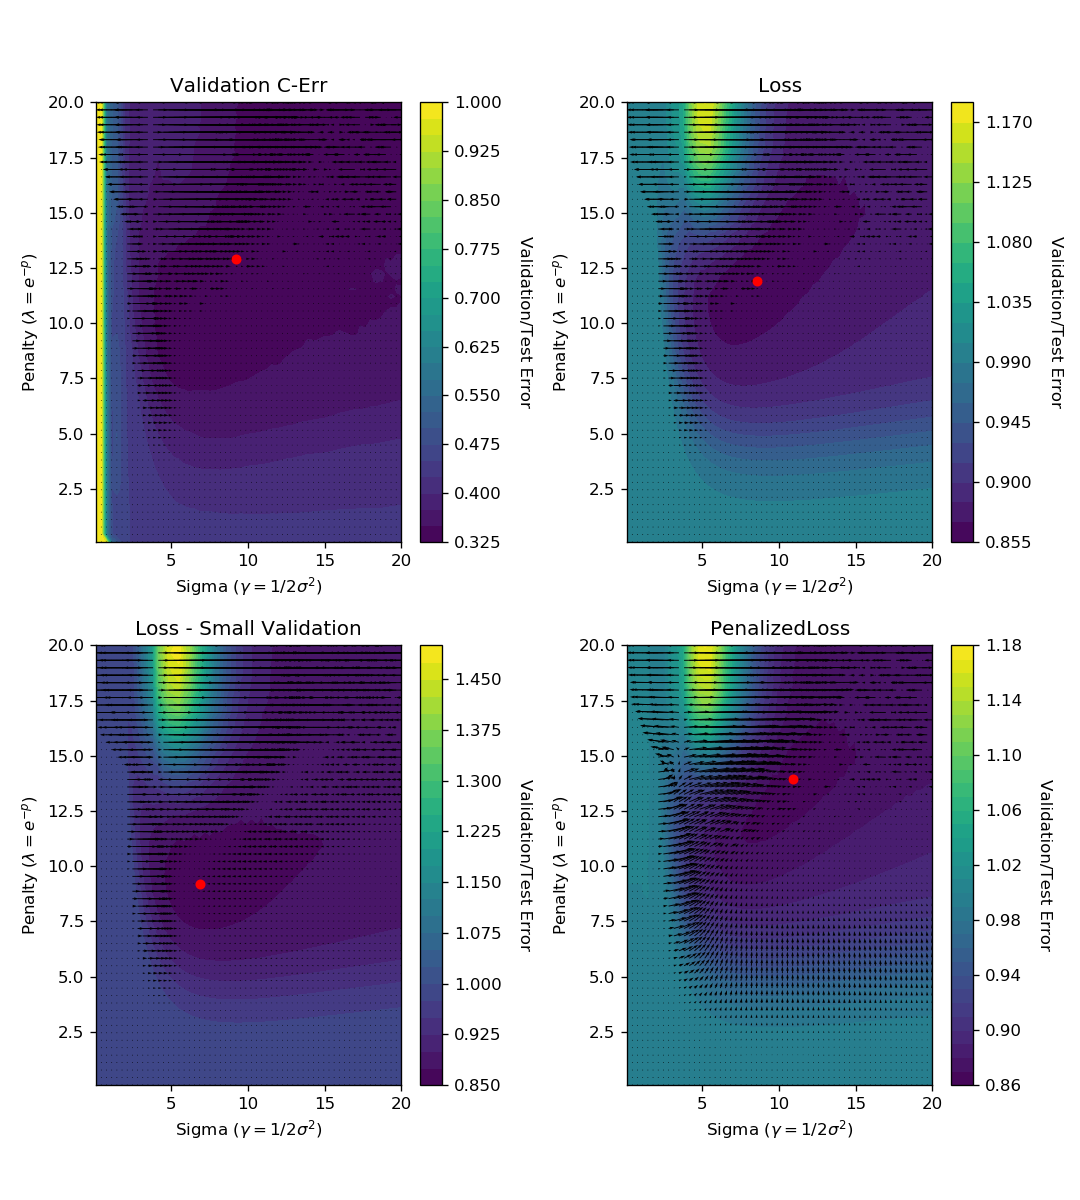

In [22]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(9,10))
ax = ax.flatten()
levels = 30
grads = pd.read_csv("./logs/gd_map_ho-higgs_1604413851305.csv")
plot_quiver_contour(grads, scale=1, plot_min=True, levels=levels, loss_label="test_c-error", 
                    title="Validation C-Err", ax=ax[0])
plot_quiver_contour(grads, scale=1, plot_min=True, levels=levels, loss_label="loss", 
                    title="Loss", ax=ax[1])

grads = pd.read_csv("./logs/gd_map_ho-higgs_1604397535342.csv")
plot_quiver_contour(grads, scale=1, plot_min=True, levels=levels, loss_label="loss", 
                    title="PenalizedLoss", ax=ax[3])
grads = pd.read_csv("./logs/gd_map_ho-higgs_1604400378218.csv")
plot_quiver_contour(grads, scale=1, plot_min=True, levels=levels, loss_label="loss", 
                    title="Loss - Small Validation", ax=ax[2])
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [29]:
def plot_trajectory(ax, traj, cmap, norm):
    ax.plot(traj['sigma'], traj['penalty'], linewidth=1.5, c='k')
    ax.scatter(traj['sigma'], traj['penalty'], c=traj['loss'], s=25, marker='x', cmap=cmap, norm=norm)
    
def plot_traj_contour(grads, traj, plot_min=False, levels=15, title=None, loss_var="loss", ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = plt.gcf()

    cmap = plt.cm.viridis
    norm = clr.Normalize(vmin=grads[loss_var].min(), vmax=grads[loss_var].max())
    
    grads_pvt = grads[["sigma", "penalty", loss_var]].pivot("penalty", "sigma")
    X = grads_pvt.columns.levels[1].values
    Y = grads_pvt.index.values
    Z = grads_pvt.values
    Xi,Yi = np.meshgrid(X, Y)
    cobj = ax.contourf(Xi, Yi, Z, levels=levels, cmap=cmap, norm=norm)
    
    if plot_min:
        min_point = grads.iloc[grads[loss_var].argmin()]
        ax.scatter(min_point["sigma"], min_point["penalty"], s=25, c="r")

    cbar = fig.colorbar(cobj, ax=ax)
    cbar.ax.set_ylabel('Validation/Test Error', rotation=270, labelpad=18)

    if isinstance(traj, list):
        for t in traj:
            plot_trajectory(ax, t, cmap, norm)
    else:
        plot_trajectory(ax, traj, cmap, norm)
    ax.set_xlabel("Sigma ($\gamma = 1/2\sigma^2$)")
    ax.set_ylabel("Penalty ($\lambda = e^{-p}$)")
    
    if title is not None:
        ax.set_title(title)
    return fig, ax

In [272]:
# 1604335141944 - lr 0.1 hess_steps 20 flk_steps 10 outer_steps 150 seed 129 float32 PenalizedMSE
# 1604336090086 - lr 0.5 hess_steps 20 flk_steps 10 outer_steps 150 seed 129 float32 PenalizedMSE
# 1604336282136 - lr 0.1 hess_steps 20 flk_steps 20 outer_steps 150 seed 129 float32 PenalizedMSE
# 1604336627714 - lr 0.1 hess_steps 20 flk_steps 10 outer_steps 150 seed 129 float64 PenalizedMSE
# 1604399771937 - lr 0.1 hess_steps 20 flk_steps 10 outer_steps 150 seed 129 float32 MSE
# 1604399841811 - lr 0.1 hess_steps 20 flk_steps 10 outer_steps 250 seed 129 float32 MSE
# 1604399898527 - lr 0.2 hess_steps 20 flk_steps 10 outer_steps 150 seed 129 float32 MSE
# 1604411462823 - lr 0.1 hess_steps 20 flk_steps 10 outer_steps 150 seed 129 float32 MSE sigma=1
# 1604411605732 - lr 0.1 hess_steps 20 flk_steps 10 outer_steps 150 seed 129 float32 MSE sigma=3
# 1604411929862 - lr 0.1 hess_steps 20 flk_steps 10 outer_steps 150 seed 129 float32 MSE sigma=5, penalty=20
# 1604412050570 - lr 0.1 hess_steps 20 flk_steps 10 outer_steps 150 seed 129 float32 MSE sigma=5, penalty=15

trajs = [
    pd.read_csv("./logs/hotraj_ho-higgs_1604399841811.csv"),
    pd.read_csv("./logs/hotraj_ho-higgs_1604411929862.csv"),
    pd.read_csv("./logs/hotraj_ho-higgs_1604411605732.csv"),
    pd.read_csv("./logs/hotraj_ho-higgs_1604412050570.csv"),
    pd.read_csv("./logs/hotraj_ho-higgs_1604412168791.csv"),
    pd.read_csv("./logs/hotraj_ho-higgs_1604412718471.csv"),
]

<IPython.core.display.Javascript object>


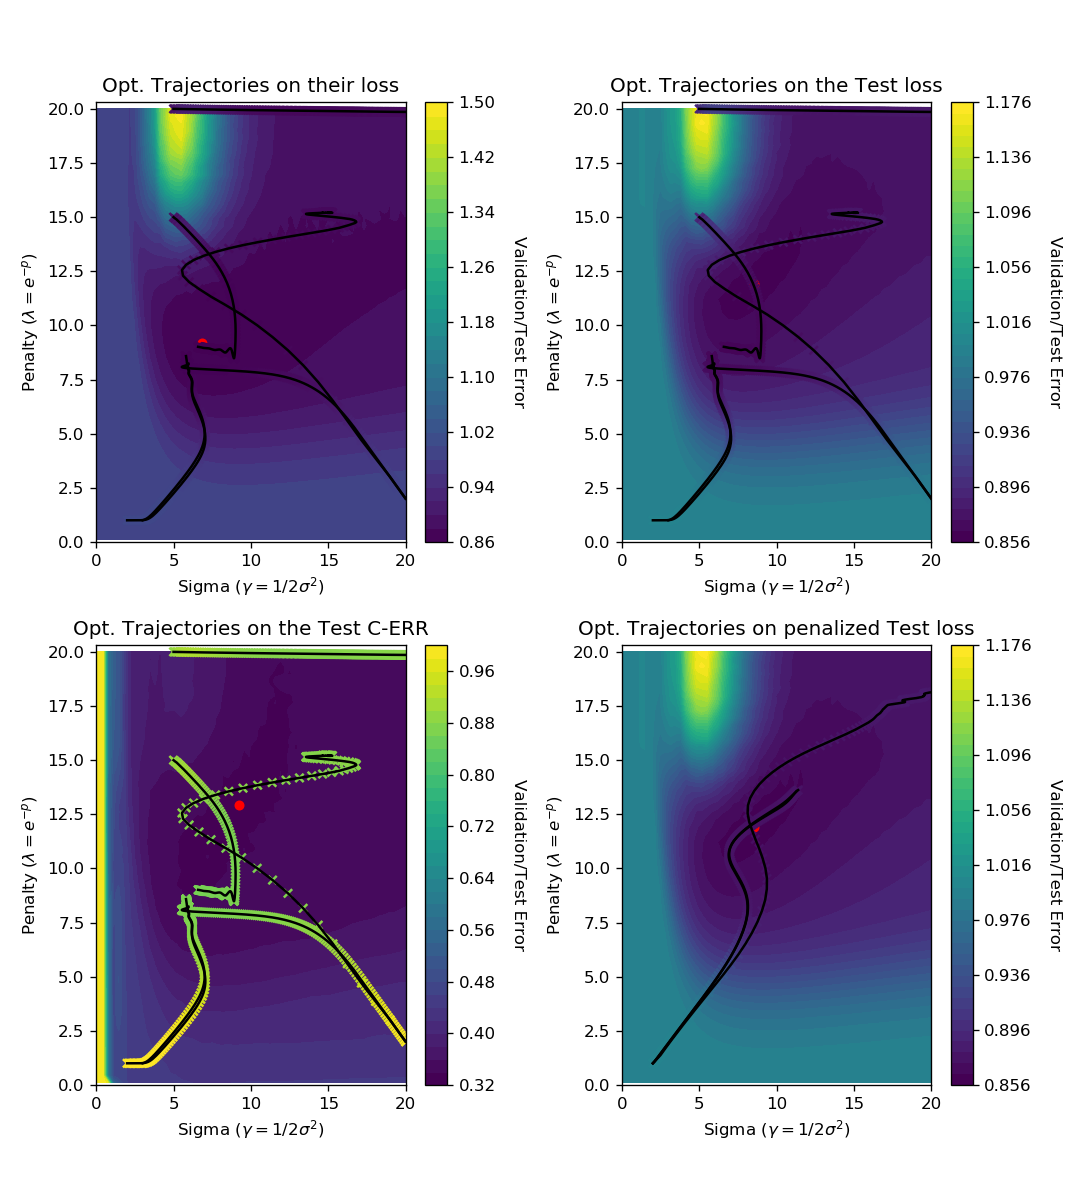

In [44]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(9,10))
ax = ax.flatten()
grads = pd.read_csv("./logs/gd_map_ho-higgs_1604400378218.csv")
trajs = [
    pd.read_csv("./logs/hotraj_ho-higgs_1604399841811.csv"),
    pd.read_csv("./logs/hotraj_ho-higgs_1604411929862.csv"),
    pd.read_csv("./logs/hotraj_ho-higgs_1604411605732.csv"),
    pd.read_csv("./logs/hotraj_ho-higgs_1604412050570.csv"),
    pd.read_csv("./logs/hotraj_ho-higgs_1604412168791.csv"),
    pd.read_csv("./logs/hotraj_ho-higgs_1604412718471.csv"),
]
plot_traj_contour(grads, trajs, plot_min=True, levels=40, loss_var="loss", ax=ax[0], 
                  title="Opt. Trajectories on their loss")
ax[0].set_xlim([0, 20])
ax[0].set_ylim([0, 20.3])

grads = pd.read_csv("./logs/gd_map_ho-higgs_1604413851305.csv")
plot_traj_contour(grads, trajs, plot_min=True, levels=40, loss_var="loss", ax=ax[1], 
                  title="Opt. Trajectories on the Test loss")
ax[1].set_xlim([0, 20])
ax[1].set_ylim([0, 20.3])

plot_traj_contour(grads, trajs, plot_min=True, levels=40, loss_var="test_c-error", ax=ax[2], 
                  title="Opt. Trajectories on the Test C-ERR")
ax[2].set_xlim([0, 20])
ax[2].set_ylim([0, 20.3])


trajs = [
    pd.read_csv("./logs/hotraj_ho-higgs_1604335141944.csv"),
    pd.read_csv("./logs/hotraj_ho-higgs_1604336090086.csv"),
    pd.read_csv("./logs/hotraj_ho-higgs_1604336282136.csv"),
]
grads = pd.read_csv("./logs/gd_map_ho-higgs_1604413851305.csv")
plot_traj_contour(grads, trajs, plot_min=True, levels=40, loss_var="loss", ax=ax[3], 
                  title="Opt. Trajectories on penalized Test loss")
ax[3].set_xlim([0, 20])
ax[3].set_ylim([0, 20.3])

fig.tight_layout(rect=[0, 0.03, 1, 0.95])